# Travelling Salesman Problem

## Introduction

The "Travelling Salesperson Problem" [[1](#TSPWiki)] refers to finding the shortest route between cities, given their relative distances. In a more general sense, given a weighted directed graph, one shall find the shortest route along the graph that goes through all the cities, where the weights correspond to the distance between cities. For example, in the following graph


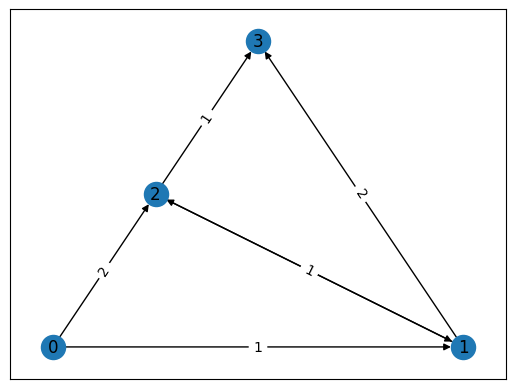

In [1]:
import networkx as nx  # noqa

nonedge = 5
graph = nx.DiGraph()
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from([(0, 1), (1, 2), (2, 1), (2, 3)], weight=1)
graph.add_edges_from([(0, 2), (1, 3)], weight=2)
pos = nx.planar_layout(graph)
nx.draw_networkx(graph, pos=pos)

labels = nx.get_edge_attributes(graph, "weight")
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
distance_matrix = nx.convert_matrix.to_numpy_array(graph, nonedge=nonedge)

one can see that the route which goes along $0\rightarrow 1\rightarrow 2\rightarrow 3$ yields a total distance 3, which is the shortest.

As many other real world problems, this task may be cast into a combinatorial optimization problem. In this demo, we will show how the Quantum Approximate Optimization Algorithm [[2](#QAOA)] can be employed on the Classiq platform to solve the Travelling Salesperson Problem.



## Mathematical formulation

As a first step, we have to model the problem mathematically. The input is the set of distances between the cities: this is given by a matrix $w$, whose $(i,j)$ entry refers to the distance between city $i$ to city $j$. The output of the model is an optimized route. Any route can be captured by a binary matrix $x$ which states at each step (row) which city was visited (column):
$\begin{aligned}
x_{ij} =
\begin{cases}
      1 & \text{at time step } i \text{ the route is in city } j \\
      0 & \text{else}
\end{cases}\\
\end{aligned}$

For example:
$\begin{aligned}
x=\begin{pmatrix}
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
1 & 0 & 0 & 0
\end{pmatrix}
\end{aligned}$ means that we start from city 1 go to city 3 then to city 2 and end at city 0.

#### The constrained optimization problem is thus defined as follows:

- find x, that minimizes the path distance -
  $\begin{aligned}
\min_{x_{i, p} \in \{0, 1\}}  \Sigma_{i, j} w_{i, j} \Sigma_p x_{i, p} x_{j, p + 1}\\
\end{aligned}$

(note that the inner sum over $p$ is simply an indicator for whether we go from city $i$ to city $j$)

such that:

- each point is visited once -
  $\begin{aligned}
\forall i, \hspace{0.2cm} \Sigma_p x_{i, p} = 1\\
\end{aligned}$

- in each step only a single point is visited -
  $\begin{aligned}
\forall p, \hspace{0.2cm} \Sigma_i x_{i, p} = 1\\
\end{aligned}$

#### Directed graph

In some cases, as in the graph above, not all cities are connected, and it is more proper to describe the problem with a weighted, directed graph. In that case, since we would like to find the shortest path, unconnected cities are assumed to have an infinite distance between them. For example, the graph above corresponds to the matrix

$\begin{aligned}
w=\begin{pmatrix}
\infty & 1 & 2 & \infty \\
\infty & \infty & 1 & 2 \\
\infty & 1 & \infty & 1 \\
\infty & \infty & \infty & \infty
\end{pmatrix}
\end{aligned}$

In practice we will choose a large enough weight rather than infinity.


# Solving with the Classiq platform

We go through the steps of solving the problem with the Classiq platform, using QAOA algorithm. The solution is based on defining a pyomo model for the optimization problem we would like to solve.


## Building the Pyomo model from a matrix of distances input


In [2]:
from typing import List, Tuple, cast  # noqa

import numpy as np  # noqa
import pyomo.core as pyo

In [3]:
## We define a function which gets the matrix of distances and returns a Pyomo model


def PyomoTSP(dis_mat: np.ndarray) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel("TSP")

    assert dis_mat.shape[0] == dis_mat.shape[1], "error distance matrix is not square"

    NofCities = dis_mat.shape[0]  # total number of cities
    cities = range(NofCities)  # list of cities

    # we define our variable, which is the binary matrix x: x[i, j] = 1 indicates that point i is visited at step j
    model.x = pyo.Var(cities, cities, domain=pyo.Binary)

    # we add constraints
    @model.Constraint(cities)
    def each_step_visits_one_point_rule(model, ii):
        return sum(model.x[ii, jj] for jj in range(NofCities)) == 1

    @model.Constraint(cities)
    def each_point_visited_once_rule(model, jj):
        return sum(model.x[ii, jj] for ii in range(NofCities)) == 1

    # we define our Objective function
    def is_connected(i1: int, i2: int):
        return sum(model.x[i1, kk] * model.x[i2, kk + 1] for kk in cities[:-1])

    model.cost = pyo.Objective(
        expr=sum(
            dis_mat[i1, i2] * is_connected(i1, i2) for i1, i2 in model.x.index_set()
        )
    )

    return model

## Generating a specific problem

Let us pick a specific problem: the graph introduced above.


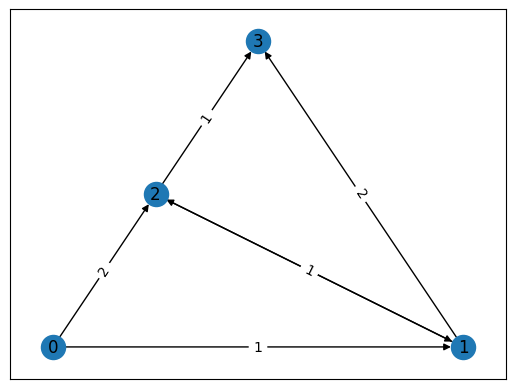

In [4]:
# We generate a graph which defines our problem
import networkx as nx  # noqa

graph = nx.DiGraph()
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from([(0, 1), (1, 2), (2, 1), (2, 3)], weight=1)
graph.add_edges_from([(0, 2), (1, 3)], weight=2)
pos = nx.planar_layout(graph)
nx.draw_networkx(graph, pos=pos)

labels = nx.get_edge_attributes(graph, "weight")
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels);

We convert the graph object into a matrix of distances and then generate a pyomo model for this example

In [5]:
nonedge = 5  # this variable refers to how much we penalize for unconnected points
distance_matrix = nx.convert_matrix.to_numpy_array(graph, nonedge=nonedge)
tsp_model = PyomoTSP(distance_matrix)

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the Classiq combinatorial optimization engine. For the quantum part of the QAOA algorithm (`QAOAConfig`) - define the number of repetitions (`num_layers`):

In [6]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=10)

For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`max_iteration`) and the $\alpha$-parameter (`alpha_cvar`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [7]:
optimizer_config = OptimizerConfig(max_iteration=50, alpha_cvar=0.4)

Lastly, we load the model, based on the problem and algorithm parameters, which we can use to solve the problem:

In [8]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=tsp_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [9]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [10]:
from classiq import write_qmod

write_qmod(qmod, "traveling_saleman_problem")

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [11]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/c7a7f06e-213e-4a50-99d9-d5032079b34b?version=0.41.0.dev39%2B79c8fd0855


We now solve the problem by calling the `execute` function on the quantum program we have generated:

In [12]:
from classiq import execute

res = execute(qprog).result()

We can check the convergence of the run:

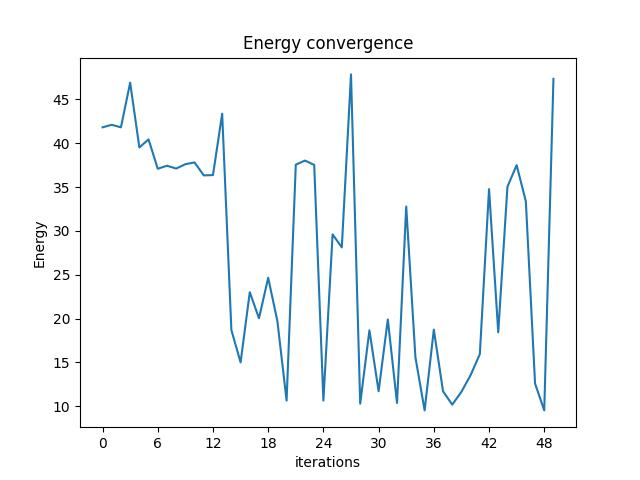

In [13]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

# Optimization Results

We can also examine the statistics of the algorithm:

In [14]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    tsp_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(5)

,probability,cost,solution,count
413,0.001,5.0,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]",1
38,0.003,5.0,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]",3
364,0.001,5.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]",1
197,0.001,5.0,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]",1
43,0.003,5.0,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",3


And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

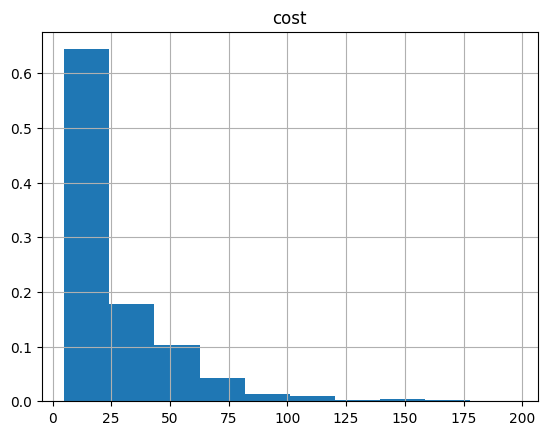

In [15]:
optimization_result.hist("cost", weights=optimization_result["probability"])

Lastly, we can compare to the classical solution of the problem:

In [16]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(tsp_model)

tsp_model.display()

Model TSP

  Variables:
    x : Size=16, Index=x_index
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :   1.0 :     1 : False : False : Binary
        (0, 1) :     0 :   0.0 :     1 : False : False : Binary
        (0, 2) :     0 :   0.0 :     1 : False : False : Binary
        (0, 3) :     0 :   0.0 :     1 : False : False : Binary
        (1, 0) :     0 :   0.0 :     1 : False : False : Binary
        (1, 1) :     0 :   1.0 :     1 : False : False : Binary
        (1, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3) :     0 :   0.0 :     1 : False : False : Binary
        (2, 0) :     0 :   0.0 :     1 : False : False : Binary
        (2, 1) :     0 :   0.0 :     1 : False : False : Binary
        (2, 2) :     0 :   1.0 :     1 : False : False : Binary
        (2, 3) :     0 :   0.0 :     1 : False : False : Binary
        (3, 0) :     0 :   0.0 :     1 : False : False : Binary
        (3, 1) :     0 :   0.0 :     1 : False : 

If we get the right solution we plot it:

In [17]:
best_classical_solution = np.array(
    [int(pyo.value(tsp_model.x[idx])) for idx in np.ndindex(distance_matrix.shape)]
)

In [18]:
best_quantum_solution = np.array(
    optimization_result.solution[optimization_result.cost.idxmin()]
)

In [19]:
if (best_classical_solution == best_quantum_solution).all():
    routesol = np.zeros(4, dtype=int)
    for k in range(4):
        routesol[k] = np.where(
            best_quantum_solution.reshape(distance_matrix.shape)[k, :] == 1
        )[0]
    edgesol = list(nx.utils.pairwise(routesol))
    nx.draw_networkx(
        graph,
        pos,
        with_labels=True,
        edgelist=edgesol,
        edge_color="red",
        node_size=200,
        width=3,
    )
    nx.draw_networkx(graph, pos=pos)

    labels = nx.get_edge_attributes(graph, "weight")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    print("The route of the traveller is:", routesol)


## References

<a id='TSPWiki'>[1]</a>: [Travelling Salesperson Problem (Wikipedia)](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

<a id='QAOA'>[2]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
